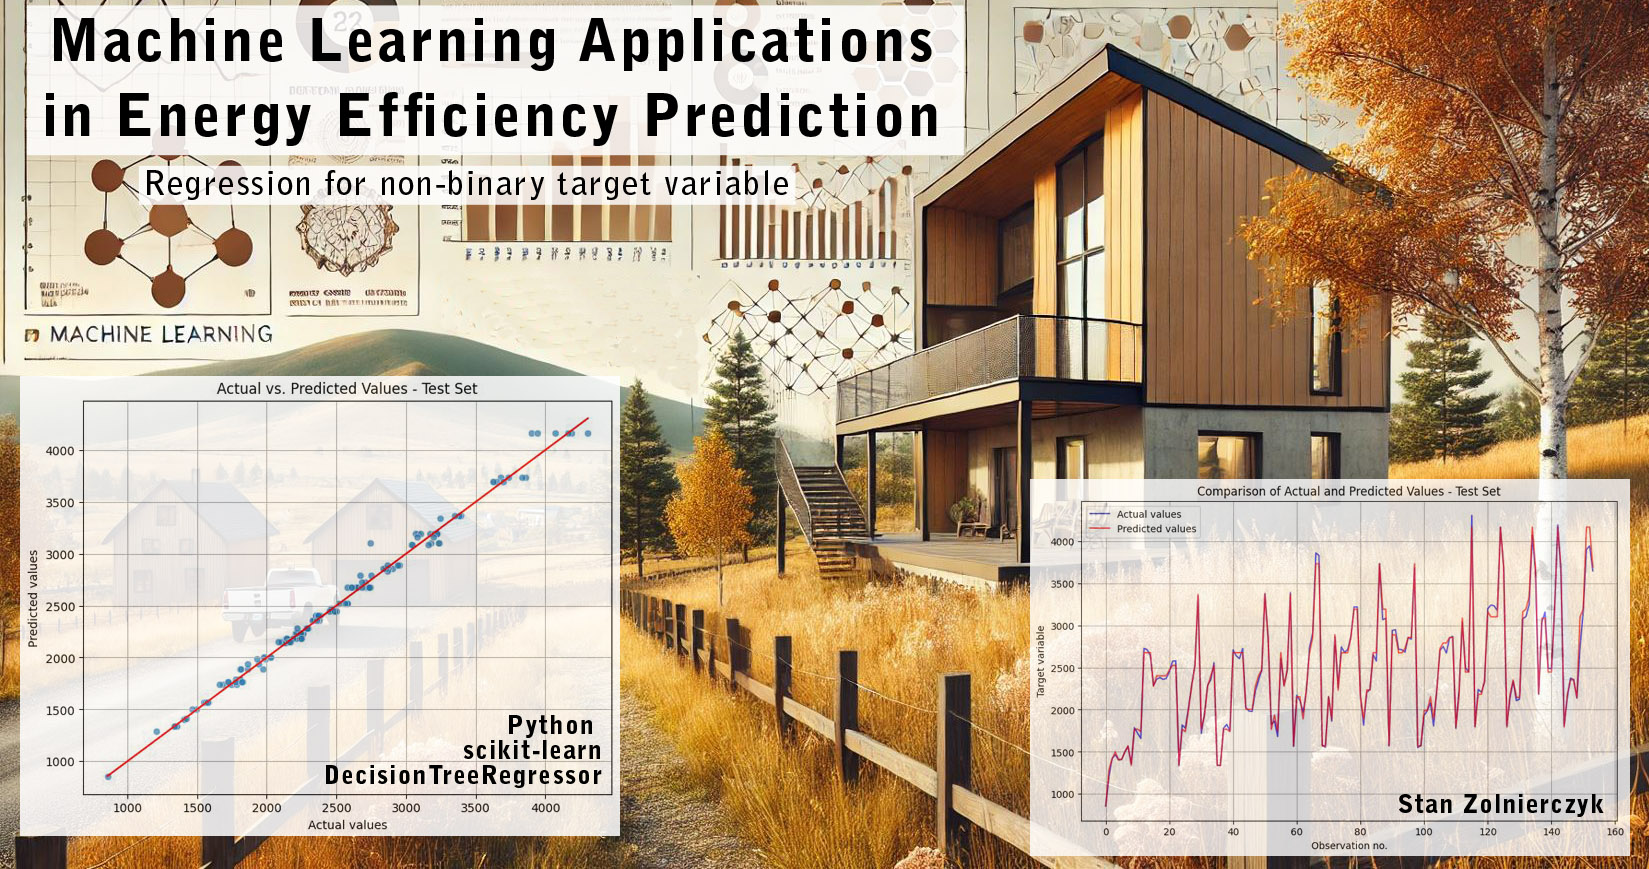

Energy efficiency is a paramount concern in modern construction due to the growing demand for sustainable development. Accurately predicting energy consumption enables smarter design decisions, better resource planning, and proactive energy management. In this article, I would like to show the practical usefulness of an Machine Learning (specifically regression for non-binary  target variable) in predicting the heating load of a building, depending on its parameters (compactness, wall area, height, glazing, etc.)

A few words about where the data comes from: it has been shared on the UC Irvine Machine Learning Repository ( https://archive.ics.uci.edu/dataset/242/energy+efficiency) under the CC BY 4.0 license. I would like to thank the authors of the original paper and give them credit for their work.

# Extract, Transform and Load (ETL)

Note: The data available for this article are synthetic (generated by external simulator, they are not real measurement data). This is not an ideal situation and I am aware that it causes some limitations, however is still useful to demonstrate the usability and correctness of the selected ML model.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import the csv, change separator
ef_data = pd.read_csv("ENB2012.csv", sep=";")
ef_data.head(10)

,RelativeCompactness,SurfaceArea,WallArea,RoofArea,OverallHeight,Orientation,GlazingArea,GlazingAreaDistribution,HeatingLoad,CoolingLoad
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
5,0.90,563.5,318.5,122.50,7.0,3,0.0,0,21.46,25.38
6,0.90,563.5,318.5,122.50,7.0,4,0.0,0,20.71,25.16
7,0.90,563.5,318.5,122.50,7.0,5,0.0,0,19.68,29.60
8,0.86,588.0,294.0,147.00,7.0,2,0.0,0,19.50,27.30
9,0.86,588.0,294.0,147.00,7.0,3,0.0,0,19.95,21.97


I will generally skip the ETL Process, because I know it has already been done on this particular dataset. I'll do the basic checks only:

In [ ]:
# check for data types and basic features
ef_data.info()
ef_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RelativeCompactness      768 non-null    float64
 1   SurfaceArea              768 non-null    float64
 2   WallArea                 768 non-null    float64
 3   RoofArea                 768 non-null    float64
 4   OverallHeight            768 non-null    float64
 5   Orientation              768 non-null    int64  
 6   GlazingArea              768 non-null    float64
 7   GlazingAreaDistribution  768 non-null    int64  
 8   HeatingLoad              768 non-null    float64
 9   CoolingLoad              768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


,RelativeCompactness,SurfaceArea,WallArea,RoofArea,OverallHeight,Orientation,GlazingArea,GlazingAreaDistribution,HeatingLoad,CoolingLoad
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [ ]:
# check for missing values
ef_data.isna().sum()

,0
RelativeCompactness,0
SurfaceArea,0
WallArea,0
RoofArea,0
OverallHeight,0
Orientation,0
GlazingArea,0
GlazingAreaDistribution,0
HeatingLoad,0
CoolingLoad,0


In [ ]:
# check for duplicates
ef_data.duplicated().sum()

np.int64(0)

There are no categorical values in this dataset, so class balancing will be skipped. Next step is to check for any potential outliers

In [ ]:
# check for outliers.
Q1 = ef_data.quantile(0.25)
Q3 = ef_data.quantile(0.75)
IQR = Q3 - Q1

outliers = ((ef_data < (Q1 - 1.5 * IQR)) | (ef_data > (Q3 + 1.5 * IQR))).sum()
print("Number of outliers in each column:\n", outliers)


Number of outliers in each column:
 RelativeCompactness        0
SurfaceArea                0
WallArea                   0
RoofArea                   0
OverallHeight              0
Orientation                0
GlazingArea                0
GlazingAreaDistribution    0
HeatingLoad                0
CoolingLoad                0
dtype: int64


According to the above, there is no outliers in this dataset. A default boxplot will confirm this. But a set of boxplots for each column will also show some more interesting information about variance, ranges etc.

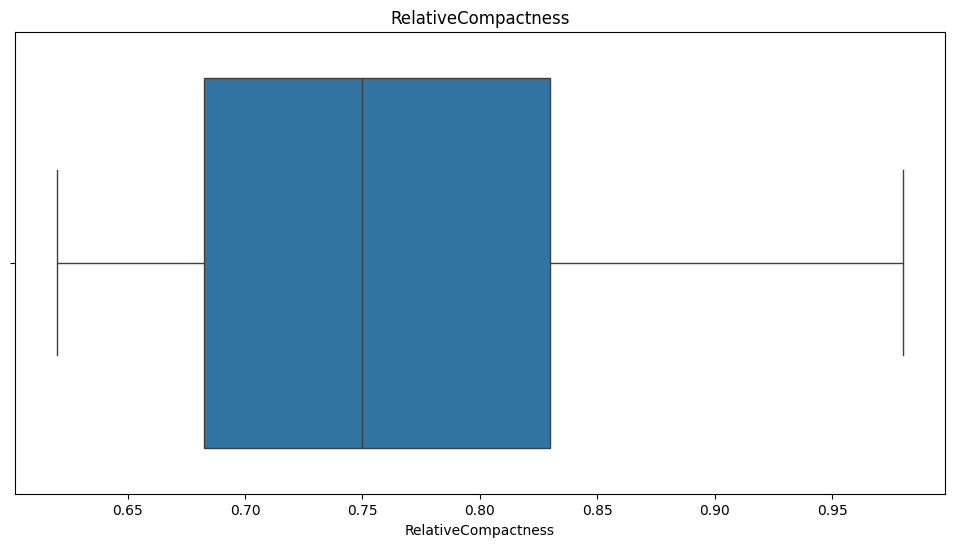

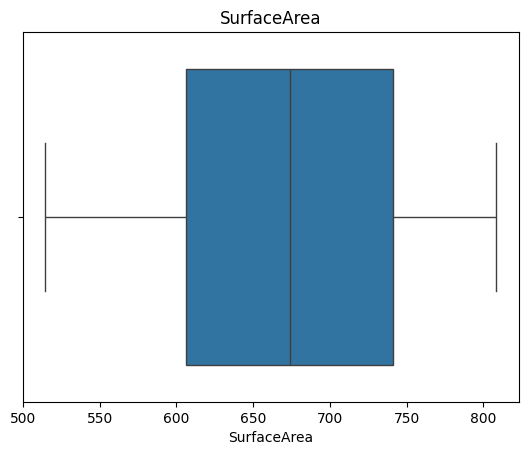

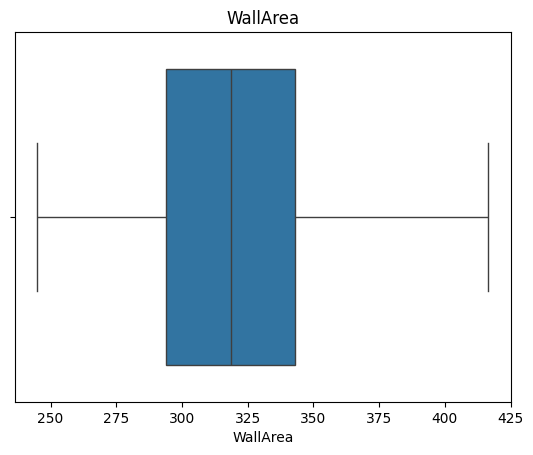

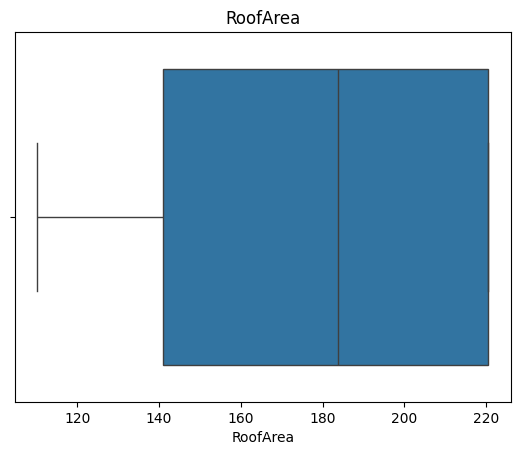

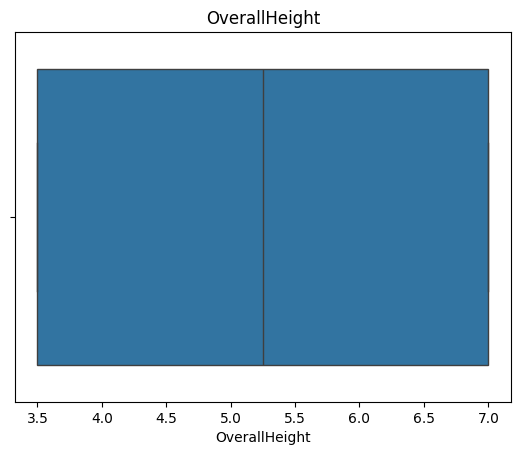

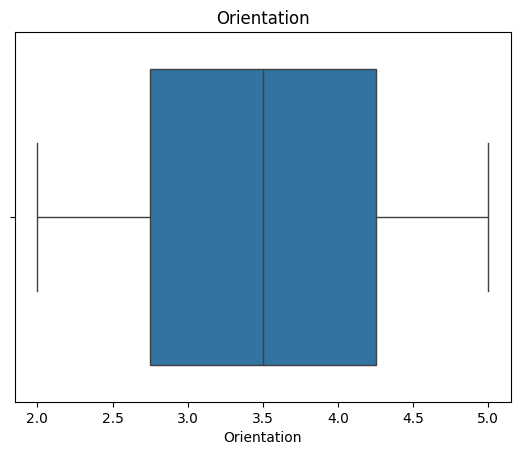

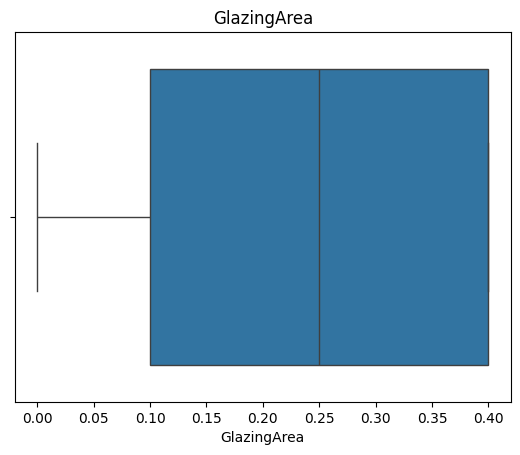

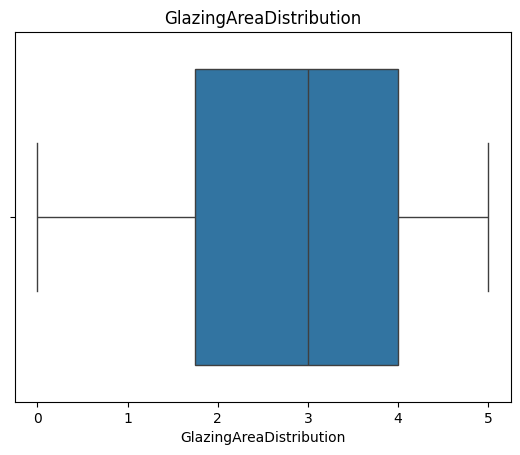

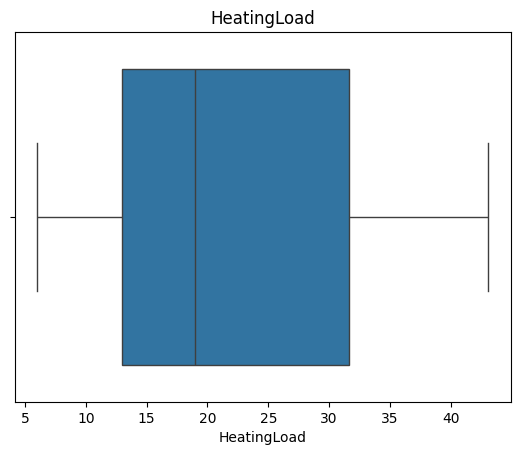

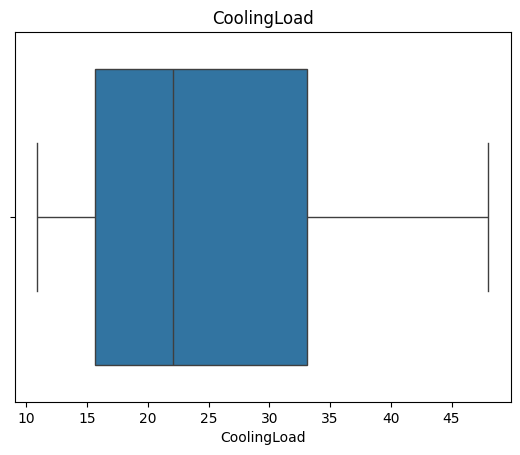

In [ ]:
plt.figure(figsize=(12,6))
ef_data_cols = list(ef_data.columns)
for num, col in enumerate(ef_data_cols, 1):
  sns.boxplot(x=ef_data[col])
  plt.title(col)
  plt.show()

One more important transformation. The following formula will generate values ​​in the TotalHeatingLoad column, based on the values ​​from the HeatingLoad, OverallHeight and RoofArea columns. The new values ​​will serve as the target variable in the Machine Learning model.

In [ ]:
ef_data["TotalHeatingLoad"] = ef_data["HeatingLoad"] * 3.5/ef_data["OverallHeight"] * ef_data["RoofArea"]

A quick look at the correlation matrix will give a better understanding of the relationships between variables, it will help to select the most important ones and prepare the data for training the Machine Learning model.

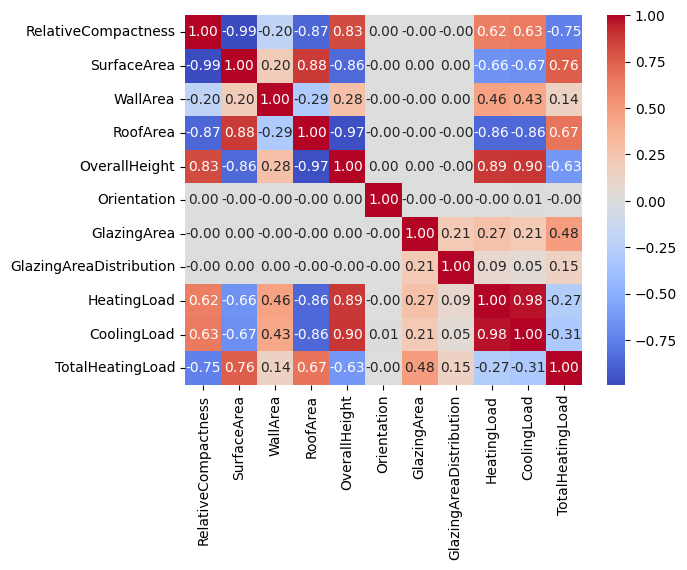

In [ ]:
corr_matrix = ef_data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

Analysis of correlations between variables (building parameters), in particular their connections with the target variable 'TotalHeatingLoad', plus some comments and conclusions.

1. RelativeCompactness and SurfaceArea are very closely correlated and practically the same. Therefore, SurfaceArea (the sum of the surface area of ​​walls, roof and floor) will be selected, because it is more natural. RelativeCompactness/SurfaceArea have quite strong correlation with the target variable.

2. RoofArea and OverallHeight are quite strongly correlated with TotalHeatingLoad as well.

3. GlazingArea also has quite a large impact on TotalHeatingLoad, this parameter certainly cannot be neglected in the Machine Learning process.

Correlations between the remaining parameters:
1. Very strong negative correlation: OverallHeight vs. RoofArea.
2. Also quite strong correlation SurfaceArea/RelativeCompactness vs. RoofArea. In both cases, shis is related to the specific parameters of the simulator that generated the data, but it makes sense in real-world data as well.

The remaining correlations are quite weak or very weak, so they can be omitted when selecting parameters for training the ML model.

Selection of the target variable:
The target variable will be the value of TotalHeatingLoad, (as a derivative of HeatingLoad), which best reflects the heating demand of the entire building in practice.

The data set also contains a second target variable CoolingLoad. But it is very closely related to heating load. Therefore, for simplicity, it will be omitted.

# Machine Learing Process starts here :-)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Target variable

In [ ]:
y = ef_data["TotalHeatingLoad"]

Model parameters

In [ ]:
x = ef_data[["SurfaceArea", "RoofArea", "OverallHeight", "GlazingArea"]]

Prepare training and test sets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

DecisionTreeRegressor will be selected, as the most versatile and robust for this taks. Hyperparamet optimization will be performed beforehand.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3, 5, 7, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# create and train DecisionTreeRegressor model with quasi-optimal parametrers
dtr = DecisionTreeRegressor(max_depth=10,  min_samples_leaf=1, min_samples_split=2, random_state=42)
dtr.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

The above model will be used to generate predictions for the target variables. Appropriate evaluation metrics will be computed afterwards to assess the model's performance.

In [ ]:
# calculate predictions for training and test set
y_train_pred = dtr.predict(x_train)
y_test_pred = dtr.predict(x_test)


In [ ]:
# calculate metrics for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

In [ ]:
# calculate metrics for the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

In [ ]:
# display the results
print(f"======= Training Set =======")
print(f"Mean Squared Error:          {mse_train:.4f}")
print(f"Root Mean Squared Error:     {rmse_train:.4f}")
print(f"Mean Absolute Error:         {mae_train:.4f}")
print(f"R²(Coeff. of Determination): {r2_train:.4f}")

print(f"\n======= Test Set =======")
print(f"Mean Squared Error:          {mse_test:.4f}")
print(f"Root Mean Squared Error:     {rmse_test:.4f}")
print(f"Mean Absolute Error:         {mae_test:.4f}")
print(f"R²(Coeff. of Determination): {r2_test:.4f}")

======= Training Set =======
Mean Squared Error:          3445.0150
Root Mean Squared Error:     58.6943
Mean Absolute Error:         37.5888
R²(Coeff. of Determination): 0.9926

======= Test Set =======
Mean Squared Error:          4002.0717
Root Mean Squared Error:     63.2619
Mean Absolute Error:         42.4149
R²(Coeff. of Determination): 0.9917


Interpretation of the results. Keep in mind that the target variables ranges aproximately from 1000 to 4000
1. Mean Squared Error and Root Mean Squared Error. RMSE of 63.26 corresponds to a relative error of less than 3%. This  indicates a very good model performance.
1. Mean Absolute Error. The MAE of 42.41 is less than 2% of the target variable range. Also very good result.
1. R² (R-squared score or Coefficient of Determination). The R² values of 0.9917 (test set) and 0.9926 (training set) indicate that the model explains over 99% of the variance in the data, which is an excellent outcome.


Visualizing the results will allow you to quickly and intuitively assess the quality of the trained model. The most common way to visualize in such cases is a graph of actual vs. predicted values.

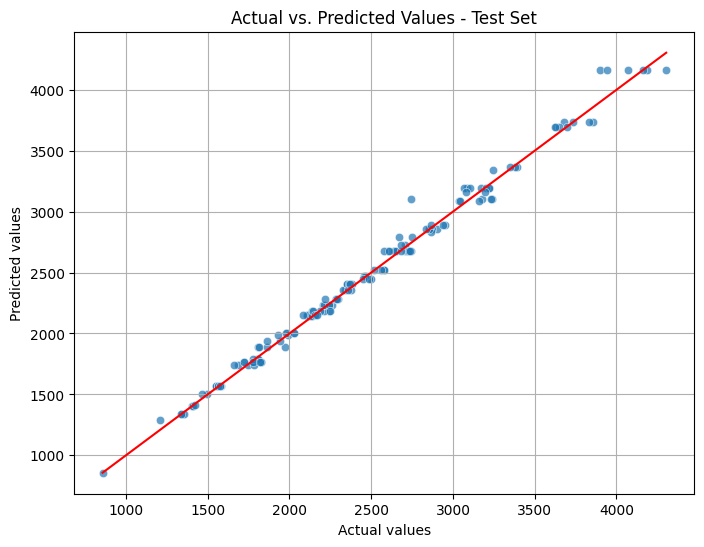

In [ ]:
# Scatterplot for actual and predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.7)
# Line of ideal fit
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='-')
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs. Predicted Values - Test Set")
plt.grid(True)
plt.show()

Another way to present the outcome is to overlay the actual and predicted values of the target variable from the test set.  

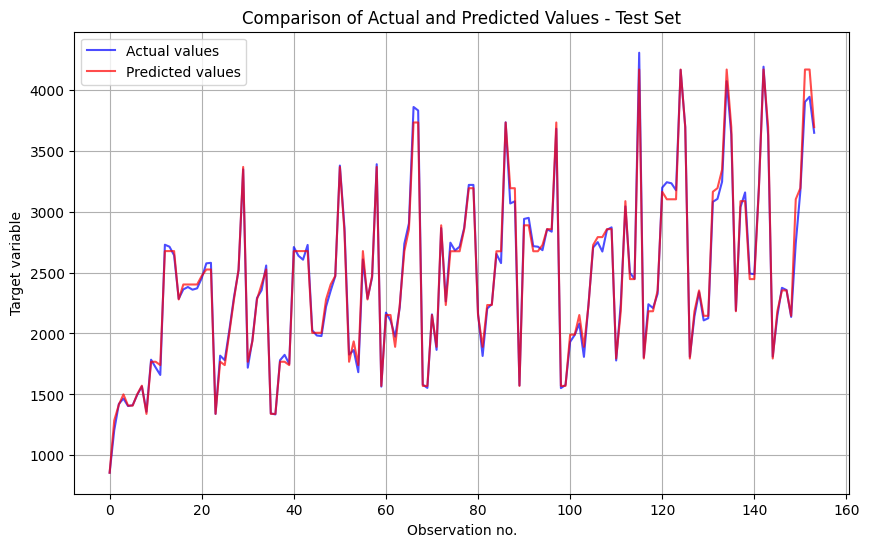

In [ ]:
# Sort the indexes to make the graph clear and easy to read
sorted_indices = np.argsort(y_test.index)
y_test_sorted = y_test.iloc[sorted_indices]
y_test_pred_sorted = y_test_pred[sorted_indices]

# Create the graph
plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted.values, label="Actual values", linestyle='-', color='blue', alpha=0.7)
plt.plot(y_test_pred_sorted, label="Predicted values", linestyle='-', color='red', alpha=0.7)

# Title and labels
plt.xlabel("Observation no.")
plt.ylabel("Target variable")
plt.title("Comparison of Actual and Predicted Values - Test Set")
plt.legend()
plt.grid(True)

# display the plot
plt.show()

#Summary and Conclusions

The DecisionTreeRegressor machine learning model from the Python Scikit Learn library proved to be very effective in coping with the given task of predicting the heating load of a building. This is confirmed by very low relative errors and very good model fit coefficients as well as visualizations of the actual and predicted values of the target variable from the test set.



The article could end here. However, I would like to show some practital aspects of how it can be used.
Firstly, the model can be used in a dashboard, where user can input building parameters and get the predicted heating load as an outcome.

In [ ]:
import ipywidgets as widgets
from IPython.display import display

dtr  # <- this is the DecisionTreeRegressor ML Model trained above

# The list of input features from the dataset
feature_names = ['SurfaceArea', 'RoofArea', 'OverallHeight', 'GlazingArea']

# The range of the sliders correrponds to min and max values of each column
feature_ranges = {
    "SurfaceArea": (515, 810, 5),  # (min, max, step)
    "RoofArea": (110, 220, 1),
    "OverallHeight": (3.5, 7, 0.5),
    "GlazingArea": (0, 0.5, 0.1)
}

# Create the sliders
inputs = {name: widgets.FloatSlider(value=(min_val + max_val) / 2,
                                    min=min_val, max=max_val, step=step,
                                    description=name, continuous_update=False)
          for name, (min_val, max_val, step) in feature_ranges.items()}

# Button to triger prediction calculations after the features are set
btn_predict = widgets.Button(
    description="Predict Heating Load",
    style={'button_color': 'brown', 'font_weight': 'bold'},
    layout=widgets.Layout(width='200px')
)
output = widgets.Output()

def predict_heating_load(_):
    # Get data from the inputs and arrange them in a DataFrame
    input_data = pd.DataFrame([[inputs[name].value for name in x_train.columns]], columns=x_train.columns)

    # Use the model to predict heating load
    heating_load = dtr.predict(input_data)[0]

    # Display the outcome
    with output:
        output.clear_output()
        print(f"Predicted Total Heating Load: {heating_load:.2f} kWh")

# Assign the function to "on click" action
btn_predict.on_click(predict_heating_load)

# Display the dashboard
display(*inputs.values(), btn_predict, output)

FloatSlider(value=662.5, continuous_update=False, description='SurfaceArea', max=810.0, min=515.0, step=5.0)

FloatSlider(value=165.0, continuous_update=False, description='RoofArea', max=220.0, min=110.0, step=1.0)

FloatSlider(value=5.25, continuous_update=False, description='OverallHeight', max=7.0, min=3.5, step=0.5)

FloatSlider(value=0.25, continuous_update=False, description='GlazingArea', max=0.5)

Button(description='Predict Heating Load', layout=Layout(width='200px'), style=ButtonStyle(button_color='brown…

Output()

Machine learning models developed in Jupyter Notebook (.ipynb) can also be successfully exported and applied in real-world scenarios. One effective way to deploy such models is by using MLflow – an open-source platform that allows to turn ML models into REST APIs and export them to popular cloud environments (Docker, Apache Spark, AWS SageMaker, Azure ML). This provides a fast and convenient path to production deployment, enabling the use of trained models in commercial applications.